> # Model 1 - SEIR

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
import numpy
import datetime
from datetime import timedelta

%matplotlib inline

## SEIR Model function
* Function From [SEIR Great APP](http://gabgoh.github.io/COVID/index.html)
![image.png](https://upload.wikimedia.org/wikipedia/commons/3/3d/SEIR.PNG)
* S ==> Susceptible : number of susceptible
* E ==> Expose : number of expose
* I ==> Infectious : number of infectious
* R ==> Recovered or Removed : number recovered (or immune) individuals. 
* We have S + E + I + R = N, this is only constant because of the (degenerate) assumption that birth and death rates are equal, N is country population.

Susceptible → Exposed → Infected → Removed, Differential Function as below (from [SEIR Great APP](http://gabgoh.github.io/COVID/index.html)): 
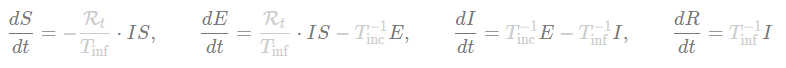
We need to solve the Differential equation to find the S,E,I,R, but what is **"R_t"**, **"T_inf"**, **"T_inc"** and how can we define those variable?
* R_0 & R_t ==> [Reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number), The definition describes the state where no other individuals are infected or immunized (naturally or through vaccination)
* T_inf ==> Average duration of the infection, 1/T_inf can be treat as individual experiences one recovery in D units of time.
* T_inc ==> Average incubation period, Many paper and article define as 5.1 ([reference](https://www.ncbi.nlm.nih.gov/pubmed/32150748), [reference2](https://www.worldometers.info/coronavirus/coronavirus-incubation-period/))

### Assume there are some intervention will cause reproduction number (R_0) reduce (such as bed nets and vaccines,government, isolation ....), have an effectiveness which decays over time 

In [ ]:
# Function code refernece from https://www.kaggle.com/anjum48/seir-model-with-intervention

# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
        
    S, E, I, R = y
    
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    
    return [S_out, E_out, I_out, R_out]

### Load dataset (Global ComfirmedCase of each country)

In [ ]:
train = pd.read_csv('../input/covid19-global-forecasting-week-3/train.csv')
test = pd.read_csv('../input/covid19-global-forecasting-week-3/test.csv')
train['Date_datetime'] = train['Date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))

### Load populations of each country

In [ ]:
pop_info = pd.read_csv('/kaggle/input/covid19-population-data/population_data.csv')
country_pop = pop_info.query('Type == "Country/Region"')
province_pop = pop_info.query('Type == "Province/State"')
country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))
province_lookup = dict(zip(province_pop['Name'], province_pop['Population']))

### Plot SEIR model and predict

In [ ]:
def plot_model_and_predict(data, pop, solution, title='SEIR model'):
    sus, exp, inf, rec = solution.y
    
    f = plt.figure(figsize=(16,5))
    ax = f.add_subplot(1,2,1)
    #ax.plot(sus, 'b', label='Susceptible');
    ax.plot(exp, 'y', label='Exposed');
    ax.plot(inf, 'r', label='Infected');
    ax.plot(rec, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');
    
    ax2 = f.add_subplot(1,2,2)
    preds = np.clip((inf + rec) * pop ,0,np.inf)
    ax2.plot(range(len(data)),preds[:len(data)],label = 'Predict ConfirmedCases')
    ax2.plot(range(len(data)),data['ConfirmedCases'])
    plt.title('Model predict and data')
    plt.ylabel("Population", fontsize=10);
    plt.xlabel("Days", fontsize=10);
    plt.legend(loc='best');

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

## Fit the SEIR model to real data
Find the best variables of SEIR model to fit the real data
* T_inf ==> Using average value 2.9 
* T_inc ==> Using average value 5.2
* **R_t** ==> find the best reproduction number by fitting the real data (if have decay function, find the paramater of decay function)
* **cfr** ==> find the best Case fatality rate, this parater is for predict Fatalities

In [ ]:
# Define all variable of SEIR model 
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period

# Define the intervention parameters (fit result, latter will show how to fit)
R_0, cfr, k, L=[ 3.95469597 , 0.04593316 , 3.      ,   15.32328881]

def time_varying_reproduction(t): 
    return R_0 / (1 + (t/L)**k)

In [ ]:
def cumsum_signal(vec):
    temp_val = 0
    vec_new = []
    for i in vec:
        if i > temp_val:
            vec_new.append(i)
            temp_val = i
        else:
            vec_new.append(temp_val)
    return vec_new

In [ ]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr = params # Paramaters, R0 and cfr 
    N = population # Population of each country
    n_infected = data['ConfirmedCases'].iloc[0] # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days # How many days want to predict
    s, e, i, r = (N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
    
    # R0 become half after intervention days
    def time_varying_reproduction(t):
        if t > 80: # we set intervention days = 80
            return R_0 * 0.5
        else:
            return R_0
    
    # Solve the SEIR differential equation.
    sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
    y_true_cases = data['ConfirmedCases'].values
    
    # Predict Fatalities by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

### Intervention by Hill function for SEIR model
* https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions

In [ ]:
# Use a Hill decayed reproduction number
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr, k, L = params # Paramaters, R0 and cfr 
    N = population # Population of each country
    n_infected = data['ConfirmedCases'].iloc[0] # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days # How many days want to predict
    s, e, i, r = (N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
    
    # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
    # Hill decay. Initial values: R_0=2.2, k=2, L=50
    def time_varying_reproduction(t): 
        return R_0 / (1 + (t/L)**k)
    
    # Solve the SEIR differential equation.
    sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
    y_true_cases = data['ConfirmedCases'].values
    
    # Predict Fatalities by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [ ]:
len(train[-7:]),len(train[:-7]),len(train)

### Function of Fit the SEIR model to real data
* Auto choose the best decay function of R_t (intervention days decay or Hill decay)
* Total case/country population is below 1, reduce country population
* If datset still no case, return 0 
* Plot the fit result and forecast trends (Infect smooth decrease by what date)
* Function being hide, there are describe in code.

In [ ]:
from matplotlib import dates
import plotly.graph_objects as go

def fit_model_new(data, area_name, initial_guess=[2.2, 0.02, 2, 50], 
              bounds=((1, 20), (0, 0.15), (1, 3), (1, 100)), make_plot=True, decay_mode = None):
    
    if area_name in ['France']:# France last data looks weird, remove it
        train = data.query('ConfirmedCases > 0').copy()[:-1]
    else:
        train = data.query('ConfirmedCases > 0').copy()
    
    ####### Split Train & Valid #######
    valid_data = train[-7:].copy()
    train_data = train[:-7].copy()
    
    ####### If this country have no ConfirmedCase, return 0 #######
    if len(train_data) == 0:
        result_zero = np.zeros((43))
        return pd.DataFrame({'ConfirmedCases':result_zero,'Fatalities':result_zero}), 0 
    
    ####### Load the population of area #######
    try:
        #population = province_lookup[area_name]
        population = pop_info[pop_info['Name']==area_name]['Population'].tolist()[0]
    except IndexError:
        print ('country not in population set, '+str(area_name))
        population = 1000000 
    
    
    if area_name == 'US':
        population = 327200000
        
    if area_name == 'Global':
        population = 7744240900
        
    cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]
    
    ####### Total case/popuplation below 1, reduce country population #######
    if cases_per_million < 1:
        #print ('reduce pop divide by 100')
        population = population/100
        
    ####### Fit the real data by minimize the MSLE #######
    res_const = minimize(eval_model_const, [2.2, 0.02], bounds=((1, 20), (0, 0.15)),
                         args=(train_data, population, False),
                         method='L-BFGS-B')

    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    ####### Align the date information #######
    test_end = datetime.datetime.strptime('2020-05-07','%Y-%m-%d')
    test_start = datetime.datetime.strptime('2020-03-26','%Y-%m-%d')
    test_period = (test_end - test_start).days
    train_max = train_data.Date_datetime.max()
    train_all_max = train.Date_datetime.max()
    train_min = train_data.Date_datetime.min()
    add_date = 0
    delta_days =(test_end - train_max).days
    train_add_time=[]

    if train_min > test_start:
        add_date = (train_min-test_start).days
        last = train_min-timedelta(add_date)
        train_add_time = np.arange(last, train_min, dtype='datetime64[D]').tolist()
        train_add_time = pd.to_datetime(train_add_time)
        dates_all = train_add_time.append(pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]')))
    else:
        dates_all = pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]'))


    ####### Auto find the best decay function ####### 
    if decay_mode is None:
        if res_const.fun < res_decay.fun :
            msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
            res = res_const

        else:
            msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
            res = res_decay
            R_0, cfr, k, L = res.x
    else:
        if decay_mode =='day_decay':
            msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
            res = res_const
        else:
            msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
            res = res_decay
            R_0, cfr, k, L = res.x

    ####### Predict the result by using best fit paramater of SEIR model ####### 
    sus, exp, inf, rec = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
       # 'ConfirmedCases': [inf[0]*population for i in range(add_date)]+(np.clip((inf + rec) * population,0,np.inf)).tolist(),
       # 'Fatalities': [rec[0]*population for i in range(add_date)]+(np.clip(rec, 0, np.inf) * population * res.x[1]).tolist()
        'Fatalities': cumsum_signal((np.clip(rec * population * res.x[1], 0, np.inf)).tolist())
    })

    y_pred_valid = y_pred.iloc[len(train_data):len(train_data)+len(valid_data)]
    #y_pred_valid = y_pred.iloc[:len(train_data)]
    y_pred_test = y_pred.iloc[-(test_period+1):]
    #y_true_valid = train_data[['ConfirmedCases', 'Fatalities']]
    y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]
    #print (len(y_pred),train_min)
    #print (y_true_valid['ConfirmedCases'])
    #print (y_pred_valid['ConfirmedCases'])
    ####### Calculate MSLE ####### 
    valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    ####### Plot the fit result of train data and forecast after 300 days ####### 
    if make_plot:
        if len(res.x)<=2:
            print(f'Validation MSLE: {valid_msle:0.5f}, using intervention days decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}')
        else:
            print(f'Validation MSLE: {valid_msle:0.5f}, using Hill decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}, K : {res.x[2]:0.5f}, L: {res.x[3]:0.5f}')
        
        ####### Plot the fit result of train data dna SEIR model trends #######

        f = plt.figure(figsize=(16,5))
        ax = f.add_subplot(1,2,1)
        ax.plot(exp, 'y', label='Exposed');
        ax.plot(inf, 'r', label='Infected');
        ax.plot(rec, 'c', label='Recovered/deceased');
        plt.title('SEIR Model Trends')
        plt.xlabel("Days", fontsize=10);
        plt.ylabel("Fraction of population", fontsize=10);
        plt.legend(loc='best');
        #train_date_remove_year = train_data['Date_datetime'].apply(lambda date:'{:%m-%d}'.format(date))
        ax2 = f.add_subplot(1,2,2)
        xaxis = train_data['Date_datetime'].tolist()
        xaxis = dates.date2num(xaxis)
        hfmt = dates.DateFormatter('%m\n%d')
        ax2.xaxis.set_major_formatter(hfmt)
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'),train_data['ConfirmedCases'],label='Confirmed Cases (train)', c='g')
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'), y_pred['ConfirmedCases'][:len(train_data)],label='Cumulative modeled infections', c='r')
        ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'), y_true_valid['ConfirmedCases'],label='Confirmed Cases (valid)', c='b')
        ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'),y_pred_valid['ConfirmedCases'],label='Cumulative modeled infections (valid)', c='y')
        plt.title('Real ConfirmedCase and Predict ConfirmedCase')
        plt.legend(loc='best');
        plt.show()
            
        ####### Forecast 300 days after by using the best paramater of train data #######
        if len(res.x)>2:
            msle, sol = eval_model_decay(res.x, train_data, population, True, 300)
        else:
            msle, sol = eval_model_const(res.x, train_data, population, True, 300)
        
        sus, exp, inf, rec = sol.y
        
        y_pred = pd.DataFrame({
            'ConfirmedCases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
            'Fatalities': cumsum_signal(np.clip(rec, 0, np.inf) * population * res.x[1])
        })
        
        ####### Plot 300 days after of each country #######
        start = train_min
        end = start + timedelta(len(y_pred))
        time_array = np.arange(start, end, dtype='datetime64[D]')

        max_day = numpy.where(inf == numpy.amax(inf))[0][0]
        where_time = time_array[max_day]
        pred_max_day = y_pred['ConfirmedCases'][max_day]
        xy_show_max_estimation = (where_time, max_day)
        
        con = y_pred['ConfirmedCases']
        max_day_con = numpy.where(con == numpy.amax(con))[0][0] # Find the max confimed case of each country
        max_con = numpy.amax(con)
        where_time_con = time_array[len(time_array)-50]
        xy_show_max_estimation_confirmed = (where_time_con, max_con)
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=time_array, y=y_pred['ConfirmedCases'].astype(int),
                            mode='lines',
                            line = dict(color='red'),
                            name='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date())))
        
        fig.add_trace(go.Scatter(x=time_array[:len(train)], y=train['ConfirmedCases'],
                            mode='lines',
                            name='Confirmed case until '+ str(train_all_max.date()),line = dict(color='green', width=4)))
        fig.add_annotation(
            x=where_time_con,
            y=max_con-(max_con/30),
            showarrow=False,
            text="Estimate Max Case around:" +str(int(max_con)),
            font=dict(
                color="Blue",
                size=15
            ))
        fig.add_annotation(
            x=time_array[len(train)-1],
            y=train['ConfirmedCases'].tolist()[-1],
            showarrow=True,
            text=f"Real Max ConfirmedCase: " +str(int(train['ConfirmedCases'].tolist()[-1]))) 
        
        fig.add_annotation(
            x=where_time,
            y=pred_max_day,
            text='Infect start decrease from: ' + str(where_time))   
        fig.update_layout(title='Estimate Confirmed Case ,'+area_name+' Total population ='+ str(int(population)), legend_orientation="h")
        fig.show()
        
        #df = pd.DataFrame({'Values': train_data['ConfirmedCases'].tolist()+y_pred['ConfirmedCases'].tolist(),'Date_datatime':time_array[:len(train_data)].tolist()+time_array.tolist(),
        #           'Real/Predict': ['ConfirmedCase' for i in range(len(train_data))]+['PredictCase' for i in range(len(y_pred))]})
        #fig = px.line(df, x="Date_datatime", y="Values",color = 'Real/Predict')
        #fig.show()
        #plt.figure(figsize = (16,7))
        #plt.plot(time_array[:len(train_data)],train_data['ConfirmedCases'],label='Confirmed case until '+ str(train_max.date()),color='g', linewidth=3.0)
        #plt.plot(time_array,y_pred['ConfirmedCases'],label='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date()),color='r', linewidth=1.0)
        #plt.annotate('Infect start decrease from: ' + str(where_time), xy=xy_show_max_estimation, size=15, color="black")
        #plt.annotate('max Confirmedcase: ' + str(int(max_con)), xy=xy_show_max_estimation_confirmed, size=15, color="black")
        #plt.title('Estimate Confirmed Case '+area_name+' Total population ='+ str(int(population)))
        #plt.legend(loc='lower right')
        #plt.show()


    return y_pred_test, valid_msle

## Predict all Country/Region and Province/States
* Counting all Country/Region MSLE & predict
* If MSLE is lower than 1 , using PR model to retrain and check the performance

In [ ]:
import numpy
validation_scores = []
validation_county = []
validation_country = []
for country in tqdm(train['Country_Region'].unique()):
    country_pd_train = train[train['Country_Region']==country]
    #if country_pd_train['Province_State'].isna().unique()==True:
    if len(country_pd_train['Province_State'].unique())<2:
        predict_test, score = fit_model_new(country_pd_train,country,make_plot=False)
        if score ==0:
            print(f'{country} no case')
        validation_scores.append(score)
        validation_county.append(country)
        validation_country.append(country)
        test.loc[test['Country_Region']==country,'ConfirmedCases'] = predict_test['ConfirmedCases'].tolist()
        test.loc[test['Country_Region']==country,'Fatalities'] = predict_test['Fatalities'].tolist()
    else:
        for state in country_pd_train['Province_State'].unique():
            if state != state: # check nan
                state_pd = country_pd_train[country_pd_train['Province_State'].isna()]
                predict_test, score = fit_model_new(state_pd,state,make_plot=False)
                if score ==0:
                    print(f'{country} / {state} no case')
                validation_scores.append(score)
                validation_county.append(state)
                validation_country.append(country)
                test.loc[(test['Country_Region']==country)&(test['Province_State'].isna()),'ConfirmedCases'] = predict_test['ConfirmedCases'].tolist()
                test.loc[(test['Country_Region']==country)&(test['Province_State'].isna()),'Fatalities'] = predict_test['Fatalities'].tolist()
            else:
                state_pd = country_pd_train[country_pd_train['Province_State']==state]
                predict_test, score = fit_model_new(state_pd,state,make_plot=False)
                if score ==0:
                    print(f'{country} / {state} no case')
                validation_scores.append(score)
                validation_county.append(state)
                validation_country.append(country)
                test.loc[(test['Country_Region']==country)&(test['Province_State']==state),'ConfirmedCases'] = predict_test['ConfirmedCases'].tolist()
                test.loc[(test['Country_Region']==country)&(test['Province_State']==state),'Fatalities'] = predict_test['Fatalities'].tolist()
         #   print(f'{country} {state} {score:0.5f}')
            
print(f'Mean validation score: {np.average(validation_scores):0.5f}')

In [ ]:
validation_scores = pd.DataFrame({'country/state':validation_country,'country':validation_county,'MSLE':validation_scores})
validation_scores.sort_values(by=['MSLE'], ascending=False).head(20)

In [ ]:
large_msle = validation_scores[validation_scores['MSLE']>1]

## Retrain PR model for MSLE>1 countries
* If MSLE of PR model lower than SEIR model, than use PR model as predict result

In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

for country in large_msle['country'].unique():
    if (country!= country)==False: # check None
        #print ('training model for country ==>'+country)
        country_pd_train = train[train['Country_Region']==country]
        country_pd_test = test[test['Country_Region']==country]
        if len(country_pd_train)==0:
            country_pd_train = train[train['Province_State']==country]
            country_pd_test = test[test['Province_State']==country]

            x = np.array(range(len(country_pd_train))).reshape((-1,1))[:-7]
            valid_x = np.array(range(len(country_pd_train))).reshape((-1,1))[-7:]
            y = country_pd_train['ConfirmedCases'][:-7]
            valid_y = country_pd_train['ConfirmedCases'][-7:]
            y_fat = country_pd_train['Fatalities'][:-7]
            valid_y_fat = country_pd_train['Fatalities'][-7:]
            
            model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                             ('linear', LinearRegression(fit_intercept=False))])
            model = model.fit(x, y)

            model_fat = Pipeline([('poly', PolynomialFeatures(degree=2)),
                             ('linear', LinearRegression(fit_intercept=False))])
            model_fat = model_fat.fit(x, y_fat)
            
            predict_y = model.predict(valid_x)
            predict_yfat = model_fat.predict(valid_x)
            score = mean_squared_log_error(np.clip(valid_y,0,np.inf), np.clip(predict_y,0,np.inf))
            score_fat = mean_squared_log_error(np.clip(valid_y_fat,0,np.inf), np.clip(predict_yfat,0,np.inf))
            score = (score+score_fat)/2

            print(f'{country} {score:0.5f}')
            if score < large_msle[large_msle['country']==country]['MSLE'].tolist()[0]:
                validation_scores.loc[validation_scores['country']==country,'MSLE'] = score
                predict_x = (np.array(range(len(country_pd_test)))+50).reshape((-1,1))
                test.loc[test['Province_State']==country,'ConfirmedCases'] = model.predict(predict_x)
                test.loc[test['Province_State']==country,'Fatalities'] = model_fat.predict(predict_x)
        else:
            x = np.array(range(len(country_pd_train))).reshape((-1,1))[:-7]
            valid_x = np.array(range(len(country_pd_train))).reshape((-1,1))[-7:]
            y = country_pd_train['ConfirmedCases'][:-7]
            valid_y = country_pd_train['ConfirmedCases'][-7:]
            y_fat = country_pd_train['Fatalities'][:-7]
            valid_y_fat = country_pd_train['Fatalities'][-7:]
            
            model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                             ('linear', LinearRegression(fit_intercept=False))])
            model = model.fit(x, y)

            model_fat = Pipeline([('poly', PolynomialFeatures(degree=2)),
                             ('linear', LinearRegression(fit_intercept=False))])
            model_fat = model_fat.fit(x, y_fat)
            
            predict_y = model.predict(valid_x)
            predict_yfat = model_fat.predict(valid_x)
            score = mean_squared_log_error(np.clip(valid_y,0,np.inf), np.clip(predict_y,0,np.inf))
            score_fat = mean_squared_log_error(np.clip(valid_y_fat,0,np.inf), np.clip(predict_yfat,0,np.inf))
            score = (score+score_fat)/2

            print(f'{country} {score:0.5f}')
            if score < large_msle[large_msle['country']==country]['MSLE'].tolist()[0]:
                validation_scores.loc[validation_scores['country']==country,'MSLE'] = score
                predict_x = (np.array(range(len(country_pd_test)))+50).reshape((-1,1))
                test.loc[test['Country_Region']==country,'ConfirmedCases'] = model.predict(predict_x)
                test.loc[test['Country_Region']==country,'Fatalities'] = model_fat.predict(predict_x)

## Submit result

In [ ]:
val_soces = validation_scores['MSLE'].tolist()
print(f'Mean validation score: {np.average(val_soces):0.5f}')

In [ ]:
submit = pd.read_csv('../input/covid19-global-forecasting-week-3/submission.csv')
submit['Fatalities'] = test['Fatalities'].astype('float')
submit['ConfirmedCases'] = test['ConfirmedCases'].astype('float')
submit.to_csv('submission.csv',index=False)

# Model 2 - XGB CNN

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

from tensorflow.keras.optimizers import Nadam
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as KL
from datetime import timedelta
import numpy as np
import pandas as pd


import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge

import datetime
import gc
from tqdm import tqdm

In [ ]:
def get_cpmp_sub(save_oof=False, save_public_test=False):
    train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-3/train.csv')
    train['Province_State'].fillna('', inplace=True)
    train['Date'] = pd.to_datetime(train['Date'])
    train['day'] = train.Date.dt.dayofyear
    #train = train[train.day <= 85]
    train['geo'] = ['_'.join(x) for x in zip(train['Country_Region'], train['Province_State'])]
    train

    test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-3/test.csv')
    test['Province_State'].fillna('', inplace=True)
    test['Date'] = pd.to_datetime(test['Date'])
    test['day'] = test.Date.dt.dayofyear
    test['geo'] = ['_'.join(x) for x in zip(test['Country_Region'], test['Province_State'])]
    test

    day_min = train['day'].min()
    train['day'] -= day_min
    test['day'] -= day_min

    min_test_val_day = test.day.min()
    max_test_val_day = train.day.max()
    max_test_day = test.day.max()
    num_days = max_test_day + 1

    min_test_val_day, max_test_val_day, num_days

    train['ForecastId'] = -1
    test['Id'] = -1
    test['ConfirmedCases'] = 0
    test['Fatalities'] = 0

    debug = False

    data = pd.concat([train,
                      test[test.day > max_test_val_day][train.columns]
                     ]).reset_index(drop=True)
    if debug:
        data = data[data['geo'] >= 'France_'].reset_index(drop=True)
    #del train, test
    gc.collect()

    dates = data[data['geo'] == 'France_'].Date.values

    if 0:
        gr = data.groupby('geo')
        data['ConfirmedCases'] = gr.ConfirmedCases.transform('cummax')
        data['Fatalities'] = gr.Fatalities.transform('cummax')

    geo_data = data.pivot(index='geo', columns='day', values='ForecastId')
    num_geo = geo_data.shape[0]
    geo_data

    geo_id = {}
    for i,g in enumerate(geo_data.index):
        geo_id[g] = i


    ConfirmedCases = data.pivot(index='geo', columns='day', values='ConfirmedCases')
    Fatalities = data.pivot(index='geo', columns='day', values='Fatalities')

    if debug:
        cases = ConfirmedCases.values
        deaths = Fatalities.values
    else:
        cases = np.log1p(ConfirmedCases.values)
        deaths = np.log1p(Fatalities.values)


    def get_dataset(start_pred, num_train, lag_period):
        days = np.arange( start_pred - num_train + 1, start_pred + 1)
        lag_cases = np.vstack([cases[:, d - lag_period : d] for d in days])
        lag_deaths = np.vstack([deaths[:, d - lag_period : d] for d in days])
        target_cases = np.vstack([cases[:, d : d + 1] for d in days])
        target_deaths = np.vstack([deaths[:, d : d + 1] for d in days])
        geo_ids = np.vstack([geo_ids_base for d in days])
        country_ids = np.vstack([country_ids_base for d in days])
        return lag_cases, lag_deaths, target_cases, target_deaths, geo_ids, country_ids, days

    def update_valid_dataset(data, pred_death, pred_case):
        lag_cases, lag_deaths, target_cases, target_deaths, geo_ids, country_ids, days = data
        day = days[-1] + 1
        new_lag_cases = np.hstack([lag_cases[:, 1:], pred_case])
        new_lag_deaths = np.hstack([lag_deaths[:, 1:], pred_death]) 
        new_target_cases = cases[:, day:day+1]
        new_target_deaths = deaths[:, day:day+1] 
        new_geo_ids = geo_ids  
        new_country_ids = country_ids  
        new_days = 1 + days
        return new_lag_cases, new_lag_deaths, new_target_cases, new_target_deaths, new_geo_ids, new_country_ids, new_days

    def fit_eval(lr_death, lr_case, data, start_lag_death, end_lag_death, num_lag_case, fit, score):
        lag_cases, lag_deaths, target_cases, target_deaths, geo_ids, country_ids, days = data

        X_death = np.hstack([lag_cases[:, -start_lag_death:-end_lag_death], country_ids])
        X_death = np.hstack([lag_deaths[:, -num_lag_case:], country_ids])
        X_death = np.hstack([lag_cases[:, -start_lag_death:-end_lag_death], lag_deaths[:, -num_lag_case:], country_ids])
        y_death = target_deaths
        y_death_prev = lag_deaths[:, -1:]
        if fit:
            if 0:
                keep = (y_death > 0).ravel()
                X_death = X_death[keep]
                y_death = y_death[keep]
                y_death_prev = y_death_prev[keep]
            lr_death.fit(X_death, y_death)
        y_pred_death = lr_death.predict(X_death)
        y_pred_death = np.maximum(y_pred_death, y_death_prev)

        X_case = np.hstack([lag_cases[:, -num_lag_case:], geo_ids])
        X_case = lag_cases[:, -num_lag_case:]
        y_case = target_cases
        y_case_prev = lag_cases[:, -1:]
        if fit:
            lr_case.fit(X_case, y_case)
        y_pred_case = lr_case.predict(X_case)
        y_pred_case = np.maximum(y_pred_case, y_case_prev)

        if score:
            death_score = val_score(y_death, y_pred_death)
            case_score = val_score(y_case, y_pred_case)
        else:
            death_score = 0
            case_score = 0

        return death_score, case_score, y_pred_death, y_pred_case

    def train_model(train, valid, start_lag_death, end_lag_death, num_lag_case, num_val, score=True):
        alpha = 3
        lr_death = Ridge(alpha=alpha, fit_intercept=False)
        lr_case = Ridge(alpha=alpha, fit_intercept=True)

        (train_death_score, train_case_score, train_pred_death, train_pred_case,
        ) = fit_eval(lr_death, lr_case, train, start_lag_death, end_lag_death, num_lag_case, fit=True, score=score)

        death_scores = []
        case_scores = []

        death_pred = []
        case_pred = []

        for i in range(num_val):

            (valid_death_score, valid_case_score, valid_pred_death, valid_pred_case,
            ) = fit_eval(lr_death, lr_case, valid, start_lag_death, end_lag_death, num_lag_case, fit=False, score=score)

            death_scores.append(valid_death_score)
            case_scores.append(valid_case_score)
            death_pred.append(valid_pred_death)
            case_pred.append(valid_pred_case)

            if 0:
                print('val death: %0.3f' %  valid_death_score,
                      'val case: %0.3f' %  valid_case_score,
                      'val : %0.3f' %  np.mean([valid_death_score, valid_case_score]),
                      flush=True)
            valid = update_valid_dataset(valid, valid_pred_death, valid_pred_case)

        if score:
            death_scores = np.sqrt(np.mean([s**2 for s in death_scores]))
            case_scores = np.sqrt(np.mean([s**2 for s in case_scores]))
            if 0:
                print('train death: %0.3f' %  train_death_score,
                      'train case: %0.3f' %  train_case_score,
                      'val death: %0.3f' %  death_scores,
                      'val case: %0.3f' %  case_scores,
                      'val : %0.3f' % ( (death_scores + case_scores) / 2),
                      flush=True)
            else:
                print('%0.4f' %  case_scores,
                      ', %0.4f' %  death_scores,
                      '= %0.4f' % ( (death_scores + case_scores) / 2),
                      flush=True)
        death_pred = np.hstack(death_pred)
        case_pred = np.hstack(case_pred)
        return death_scores, case_scores, death_pred, case_pred

    countries = [g.split('_')[0] for g in geo_data.index]
    countries = pd.factorize(countries)[0]

    country_ids_base = countries.reshape((-1, 1))
    ohe = OneHotEncoder(sparse=False)
    country_ids_base = 0.2 * ohe.fit_transform(country_ids_base)
    country_ids_base.shape

    geo_ids_base = np.arange(num_geo).reshape((-1, 1))
    ohe = OneHotEncoder(sparse=False)
    geo_ids_base = 0.1 * ohe.fit_transform(geo_ids_base)
    geo_ids_base.shape

    def val_score(true, pred):
        pred = np.log1p(np.round(np.expm1(pred) - 0.2))
        return np.sqrt(mean_squared_error(true.ravel(), pred.ravel()))

    def val_score(true, pred):
        return np.sqrt(mean_squared_error(true.ravel(), pred.ravel()))



    start_lag_death, end_lag_death = 14, 6,
    num_train = 5
    num_lag_case = 14
    lag_period = max(start_lag_death, num_lag_case)

    def get_oof(start_val_delta=0):   
        start_val = min_test_val_day + start_val_delta
        last_train = start_val - 1
        num_val = max_test_val_day - start_val + 1
        print(dates[start_val], start_val, num_val)
        train_data = get_dataset(last_train, num_train, lag_period)
        valid_data = get_dataset(start_val, 1, lag_period)
        _, _, val_death_preds, val_case_preds = train_model(train_data, valid_data, 
                                                            start_lag_death, end_lag_death, num_lag_case, num_val)

        pred_deaths = Fatalities.iloc[:, start_val:start_val+num_val].copy()
        pred_deaths.iloc[:, :] = np.expm1(val_death_preds)
        pred_deaths = pred_deaths.stack().reset_index()
        pred_deaths.columns = ['geo', 'day', 'Fatalities']
        pred_deaths

        pred_cases = ConfirmedCases.iloc[:, start_val:start_val+num_val].copy()
        pred_cases.iloc[:, :] = np.expm1(val_case_preds)
        pred_cases = pred_cases.stack().reset_index()
        pred_cases.columns = ['geo', 'day', 'ConfirmedCases']
        pred_cases

        sub = train[['Date', 'Id', 'geo', 'day']]
        sub = sub.merge(pred_cases, how='left', on=['geo', 'day'])
        sub = sub.merge(pred_deaths, how='left', on=['geo', 'day'])
        #sub = sub.fillna(0)
        sub = sub[sub.day >= start_val]
        sub = sub[['Id', 'ConfirmedCases', 'Fatalities']].copy()
        return sub


    if save_oof:
        for start_val_delta, date in zip(range(3, -8, -3),
                                  ['2020-03-22', '2020-03-19', '2020-03-16', '2020-03-13']):
            print(date, end=' ')
            oof = get_oof(start_val_delta)
            oof.to_csv('../submissions/cpmp-%s.csv' % date, index=None)

    def get_sub(start_val_delta=0):   
        start_val = min_test_val_day + start_val_delta
        last_train = start_val - 1
        num_val = max_test_val_day - start_val + 1
        print(dates[last_train], start_val, num_val)
        num_lag_case = 14
        train_data = get_dataset(last_train, num_train, lag_period)
        valid_data = get_dataset(start_val, 1, lag_period)
        _, _, val_death_preds, val_case_preds = train_model(train_data, valid_data, 
                                                            start_lag_death, end_lag_death, num_lag_case, num_val)

        pred_deaths = Fatalities.iloc[:, start_val:start_val+num_val].copy()
        pred_deaths.iloc[:, :] = np.expm1(val_death_preds)
        pred_deaths = pred_deaths.stack().reset_index()
        pred_deaths.columns = ['geo', 'day', 'Fatalities']
        pred_deaths

        pred_cases = ConfirmedCases.iloc[:, start_val:start_val+num_val].copy()
        pred_cases.iloc[:, :] = np.expm1(val_case_preds)
        pred_cases = pred_cases.stack().reset_index()
        pred_cases.columns = ['geo', 'day', 'ConfirmedCases']
        pred_cases

        sub = test[['Date', 'ForecastId', 'geo', 'day']]
        sub = sub.merge(pred_cases, how='left', on=['geo', 'day'])
        sub = sub.merge(pred_deaths, how='left', on=['geo', 'day'])
        sub = sub.fillna(0)
        sub = sub[['ForecastId', 'ConfirmedCases', 'Fatalities']]
        return sub
        return sub


    known_test = train[['geo', 'day', 'ConfirmedCases', 'Fatalities']
              ].merge(test[['geo', 'day', 'ForecastId']], how='left', on=['geo', 'day'])
    known_test = known_test[['ForecastId', 'ConfirmedCases', 'Fatalities']][known_test.ForecastId.notnull()].copy()
    known_test

    unknow_test = test[test.day > max_test_val_day]
    unknow_test

    def get_final_sub():   
        start_val = max_test_val_day + 1
        last_train = start_val - 1
        num_val = max_test_day - start_val + 1
        print(dates[last_train], start_val, num_val)
        num_lag_case = num_val + 3
        train_data = get_dataset(last_train, num_train, lag_period)
        valid_data = get_dataset(start_val, 1, lag_period)
        (_, _, val_death_preds, val_case_preds
        ) = train_model(train_data, valid_data, start_lag_death, end_lag_death, num_lag_case, num_val, score=False)

        pred_deaths = Fatalities.iloc[:, start_val:start_val+num_val].copy()
        pred_deaths.iloc[:, :] = np.expm1(val_death_preds)
        pred_deaths = pred_deaths.stack().reset_index()
        pred_deaths.columns = ['geo', 'day', 'Fatalities']
        pred_deaths

        pred_cases = ConfirmedCases.iloc[:, start_val:start_val+num_val].copy()
        pred_cases.iloc[:, :] = np.expm1(val_case_preds)
        pred_cases = pred_cases.stack().reset_index()
        pred_cases.columns = ['geo', 'day', 'ConfirmedCases']
        pred_cases
        print(unknow_test.shape, pred_deaths.shape, pred_cases.shape)

        sub = unknow_test[['Date', 'ForecastId', 'geo', 'day']]
        sub = sub.merge(pred_cases, how='left', on=['geo', 'day'])
        sub = sub.merge(pred_deaths, how='left', on=['geo', 'day'])
        #sub = sub.fillna(0)
        sub = sub[['ForecastId', 'ConfirmedCases', 'Fatalities']]
        sub = pd.concat([known_test, sub])
        return sub

    if save_public_test:
        sub = get_sub()
    else:
        sub = get_final_sub()
    return sub

In [ ]:
def get_nn_sub():
    df = pd.read_csv("../input/covid19-global-forecasting-week-3/train.csv")
    sub_df = pd.read_csv("../input/covid19-global-forecasting-week-3/test.csv")

    coo_df = pd.read_csv("../input/covid19week1/train.csv").rename(columns={"Country/Region": "Country_Region"})
    coo_df = coo_df.groupby("Country_Region")[["Lat", "Long"]].mean().reset_index()
    coo_df = coo_df[coo_df["Country_Region"].notnull()]

    loc_group = ["Province_State", "Country_Region"]

    def preprocess(df):
        df["Date"] = df["Date"].astype("datetime64[ms]")
        df["days"] = (df["Date"] - pd.to_datetime("2020-01-01")).dt.days
        df["weekend"] = df["Date"].dt.dayofweek//5

        df = df.merge(coo_df, how="left", on="Country_Region")
        df["Lat"] = (df["Lat"] // 30).astype(np.float32).fillna(0)
        df["Long"] = (df["Long"] // 60).astype(np.float32).fillna(0)

        for col in loc_group:
            df[col].fillna("none", inplace=True)
        return df

    df = preprocess(df)
    sub_df = preprocess(sub_df)

    print(df.shape)

    TARGETS = ["ConfirmedCases", "Fatalities"]

    for col in TARGETS:
        df[col] = np.log1p(df[col])

    NUM_SHIFT = 5

    features = ["Lat", "Long"]

    for s in range(1, NUM_SHIFT+1):
        for col in TARGETS:
            df["prev_{}_{}".format(col, s)] = df.groupby(loc_group)[col].shift(s)
            features.append("prev_{}_{}".format(col, s))

    df = df[df["Date"] >= df["Date"].min() + timedelta(days=NUM_SHIFT)].copy()

    TEST_FIRST = sub_df["Date"].min() # pd.to_datetime("2020-03-13") #
    TEST_DAYS = (df["Date"].max() - TEST_FIRST).days + 1

    dev_df, test_df = df[df["Date"] < TEST_FIRST].copy(), df[df["Date"] >= TEST_FIRST].copy()

    def nn_block(input_layer, size, dropout_rate, activation):
        out_layer = KL.Dense(size, activation=None)(input_layer)
        #out_layer = KL.BatchNormalization()(out_layer)
        out_layer = KL.Activation(activation)(out_layer)
        out_layer = KL.Dropout(dropout_rate)(out_layer)
        return out_layer


    def get_model():
        inp = KL.Input(shape=(len(features),))

        hidden_layer = nn_block(inp, 64, 0.0, "relu")
        gate_layer = nn_block(hidden_layer, 32, 0.0, "sigmoid")
        hidden_layer = nn_block(hidden_layer, 32, 0.0, "relu")
        hidden_layer = KL.multiply([hidden_layer, gate_layer])

        out = KL.Dense(len(TARGETS), activation="linear")(hidden_layer)

        model = tf.keras.models.Model(inputs=[inp], outputs=out)
        return model

    get_model().summary()

    def get_input(df):
        return [df[features]]

    NUM_MODELS = 10


    def train_models(df, save=False):
        models = []
        for i in range(NUM_MODELS):
            model = get_model()
            model.compile(loss="mean_squared_error", optimizer=Nadam(lr=1e-4))
            hist = model.fit(get_input(df), df[TARGETS],
                             batch_size=2048, epochs=500, verbose=0, shuffle=True)
            if save:
                model.save_weights("model{}.h5".format(i))
            models.append(model)
        return models

    models = train_models(dev_df)


    prev_targets = ['prev_ConfirmedCases_1', 'prev_Fatalities_1']

    def predict_one(df, models):
        pred = np.zeros((df.shape[0], 2))
        for model in models:
            pred += model.predict(get_input(df))/len(models)
        pred = np.maximum(pred, df[prev_targets].values)
        pred[:, 0] = np.log1p(np.expm1(pred[:, 0]) + 0.1)
        pred[:, 1] = np.log1p(np.expm1(pred[:, 1]) + 0.01)
        return np.clip(pred, None, 15)

    print([mean_squared_error(dev_df[TARGETS[i]], predict_one(dev_df, models)[:, i]) for i in range(len(TARGETS))])


    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def evaluate(df):
        error = 0
        for col in TARGETS:
            error += rmse(df[col].values, df["pred_{}".format(col)].values)
        return np.round(error/len(TARGETS), 5)


    def predict(test_df, first_day, num_days, models, val=False):
        temp_df = test_df.loc[test_df["Date"] == first_day].copy()
        y_pred = predict_one(temp_df, models)

        for i, col in enumerate(TARGETS):
            test_df["pred_{}".format(col)] = 0
            test_df.loc[test_df["Date"] == first_day, "pred_{}".format(col)] = y_pred[:, i]

        print(first_day, np.isnan(y_pred).sum(), y_pred.min(), y_pred.max())
        if val:
            print(evaluate(test_df[test_df["Date"] == first_day]))


        y_prevs = [None]*NUM_SHIFT

        for i in range(1, NUM_SHIFT):
            y_prevs[i] = temp_df[['prev_ConfirmedCases_{}'.format(i), 'prev_Fatalities_{}'.format(i)]].values

        for d in range(1, num_days):
            date = first_day + timedelta(days=d)
            print(date, np.isnan(y_pred).sum(), y_pred.min(), y_pred.max())

            temp_df = test_df.loc[test_df["Date"] == date].copy()
            temp_df[prev_targets] = y_pred
            for i in range(2, NUM_SHIFT+1):
                temp_df[['prev_ConfirmedCases_{}'.format(i), 'prev_Fatalities_{}'.format(i)]] = y_prevs[i-1]

            y_pred, y_prevs = predict_one(temp_df, models), [None, y_pred] + y_prevs[1:-1]


            for i, col in enumerate(TARGETS):
                test_df.loc[test_df["Date"] == date, "pred_{}".format(col)] = y_pred[:, i]

            if val:
                print(evaluate(test_df[test_df["Date"] == date]))

        return test_df

    test_df = predict(test_df, TEST_FIRST, TEST_DAYS, models, val=True)
    print(evaluate(test_df))

    for col in TARGETS:
        test_df[col] = np.expm1(test_df[col])
        test_df["pred_{}".format(col)] = np.expm1(test_df["pred_{}".format(col)])

    models = train_models(df, save=True)

    sub_df_public = sub_df[sub_df["Date"] <= df["Date"].max()].copy()
    sub_df_private = sub_df[sub_df["Date"] > df["Date"].max()].copy()

    pred_cols = ["pred_{}".format(col) for col in TARGETS]
    #sub_df_public = sub_df_public.merge(test_df[["Date"] + loc_group + pred_cols].rename(columns={col: col[5:] for col in pred_cols}), 
    #                                    how="left", on=["Date"] + loc_group)
    sub_df_public = sub_df_public.merge(test_df[["Date"] + loc_group + TARGETS], how="left", on=["Date"] + loc_group)

    SUB_FIRST = sub_df_private["Date"].min()
    SUB_DAYS = (sub_df_private["Date"].max() - sub_df_private["Date"].min()).days + 1

    sub_df_private = df.append(sub_df_private, sort=False)

    for s in range(1, NUM_SHIFT+1):
        for col in TARGETS:
            sub_df_private["prev_{}_{}".format(col, s)] = sub_df_private.groupby(loc_group)[col].shift(s)

    sub_df_private = sub_df_private[sub_df_private["Date"] >= SUB_FIRST].copy()

    sub_df_private = predict(sub_df_private, SUB_FIRST, SUB_DAYS, models)

    for col in TARGETS:
        sub_df_private[col] = np.expm1(sub_df_private["pred_{}".format(col)])

    sub_df = sub_df_public.append(sub_df_private, sort=False)
    sub_df["ForecastId"] = sub_df["ForecastId"].astype(np.int16)

    return sub_df[["ForecastId"] + TARGETS]

In [ ]:
sub1 = get_cpmp_sub()
sub1['ForecastId'] = sub1['ForecastId'].astype('int')

In [ ]:
sub2 = get_nn_sub()

In [ ]:
sub1.sort_values("ForecastId", inplace=True)
sub2.sort_values("ForecastId", inplace=True)
submit.sort_values("ForecastId", inplace=True)

In [ ]:
from sklearn.metrics import mean_squared_error

TARGETS = ["ConfirmedCases", "Fatalities"]

[np.sqrt(mean_squared_error(np.log1p(sub1[t].values), np.log1p(sub2[t].values))) for t in TARGETS]

In [ ]:
sub_df = sub1.copy()
for t in TARGETS:
    sub_df[t] = np.expm1(np.log1p(submit[t].values)*0.2 + np.log1p(sub1[t].values)*0.3 + np.log1p(sub2[t].values)*0.5)

In [ ]:
sub_df.to_csv("submission.csv", index=False)